## Bike Index Seattle - Data Prep

### Data cleaning for Seattle streets data

##### Objective: Recreate the study by Allen-Munley et al. (2004) for Seattle using WSDOT crash data.


#### Part 2.

I will take 

[Street Data](https://data-seattlecitygis.opendata.arcgis.com/datasets/seattle-streets)
[PDF](https://www.seattle.gov/Documents/Departments/SDOT/GIS/Seattle_Streets_OD.pdf)

In [136]:
import requests
import json
import pandas as pd
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

In [71]:
%matplotlib inline

In [2]:
url = 'https://data.seattle.gov/resource/38vd-gytv.json'

In [3]:
gisurl = 'https://opendata.arcgis.com/datasets/383027d103f042499693da22d72d10e3_0.geojson'

In [4]:
r = requests.get(gisurl)

In [5]:
streets = r.json()

In [6]:
os.getcwd()

'C:\\Users\\admin\\Documents\\Projects\\bike-index'

In [37]:
crashes = pd.read_csv('data/bike_crash.csv')

In [8]:
type(streets)

dict

In [9]:
streets['features'][0]

{'type': 'Feature',
 'properties': {'OBJECTID': 1,
  'ARTCLASS': 2,
  'COMPKEY': 1006,
  'UNITID': '00010',
  'UNITID2': '0120',
  'UNITIDSORT': '000100120',
  'UNITDESC': '1ST AVE BETWEEN SENECA ST AND UNIVERSITY ST',
  'STNAME_ORD': '1ST AVE',
  'XSTRLO': 'SENECA ST',
  'XSTRHI': 'UNIVERSITY ST',
  'ARTDESCRIPT': 'Minor Arterial',
  'OWNER': ' ',
  'STATUS': 'INSVC',
  'BLOCKNBR': 1200,
  'SPEEDLIMIT': 25,
  'SEGDIR': 'NW',
  'ONEWAY': 'N',
  'ONEWAYDIR': ' ',
  'FLOW': ' ',
  'SEGLENGTH': 306.0,
  'SURFACEWIDTH': 48,
  'SURFACETYPE_1': 'PCC',
  'SURFACETYPE_2': 'AC/PCC',
  'INTRLO': '1ST AVE AND SENECA ST',
  'DIRLO': 'NW',
  'INTKEYLO': 29611,
  'INTRHI': '1ST AVE AND UNIVERSITY ST',
  'DIRHI': 'SE',
  'NATIONHWYSYS': 'N',
  'STREETTYPE': 'Downtown Neighborhood',
  'PVMTCONDINDX1': 87,
  'PVMTCONDINDX2': 62,
  'TRANCLASS': 1,
  'TRANDESCRIPT': 'PRINCIPAL TRANSIT ROUTE',
  'SLOPE_PCT': 4,
  'PVMTCATEGORY': 'ART',
  'PARKBOULEVARD': 'N',
  'SHAPE_Length': 305.966027667416},
 'geometr

In [14]:
import geopandas as gpd
import shapely

In [16]:
from shapely.geometry import Point, LineString

In [39]:
geom = [Point(xy) for xy in zip(crashes.LONGITUDE, crashes.LATITUDE)]

In [118]:
gdf_crashes = gpd.GeoDataFrame(crashes.drop(['LATITUDE','LONGITUDE'], axis = 1),
                               geometry = geom)

In [188]:
gdf_crashes.crs

In [97]:
#gdf_crashes

In [81]:
plt.rcParams["figure.figsize"] = (20,20)

In [119]:
gdf.sindex

rtree.index.Index(bounds=[-122.43071639472724, 47.48525419603729, -122.22788968951711, 47.73414256142292], size=23806)

In [131]:
offset = 10**-4 ## approx 100m

bbox = gdf_crashes.bounds + [-offset, -offset, offset, offset]

In [132]:
hits = bbox.apply(lambda row: list(gdf.sindex.intersection(row)), axis=1)

In [134]:
max(hits)

[23792, 11434, 7188, 753]

In [170]:
tmp = pd.DataFrame({
    # index of points table
    "pt_idx": np.repeat(hits.index, hits.apply(len)),
    # ordinal position of line - access via iloc later
    "line_i": np.concatenate(hits.values)
})

In [171]:
# Join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line

tmp1 = tmp.merge(gdf.reset_index(drop=False).rename(columns={'index':'line_i'}), on="line_i")
# Join back to the original points to get their geometry
# rename the point geometry as "point"

In [172]:
crashes_tmp = gdf_crashes.reset_index(drop=False).rename(columns={'geometry':'point', 'index':'pt_idx'})

In [173]:
crashes_tmp.columns

Index(['pt_idx', 'REPORT NUMBER', 'BLOCK NUMBER', 'DATETIME', 'severity',
       'is_dry', 'is_light', 'is_clear', 'is_hit_run', 'TOTAL VEHICLES',
       'TOTAL PEDESTRIANS INVOLVED', 'TOTAL BICYCLISTS INVOLVED', 'point'],
      dtype='object')

In [174]:
tmp2 = tmp1.merge(crashes_tmp, on="pt_idx")
# Convert back to a GeoDataFrame, so we can do spatial ops

tmp3 = gpd.GeoDataFrame(tmp2, geometry="geometry", crs=gdf_crashes.crs)

In [176]:
tmp3["snap_dist"] = tmp3.geometry.distance(gpd.GeoSeries(tmp3.point))

In [177]:
tolerance = 

# Discard any lines that are greater than tolerance from points
tmp4 = tmp3.loc[tmp3.snap_dist <= tolerance]
# Sort on ascending snap distance, so that closest goes to top
tmp4 = tmp4.sort_values(by=["snap_dist"])

NameError: name 'tolerance' is not defined

In [95]:
#gdf.plot(column='TRANDESCRIPT', legend=True)

In [96]:
#gdf_crashes.plot(column='severity',legend=True)

In [46]:
point = gdf_crashes.iloc[0]['geometry']

In [49]:
gdf['geometry']

0        LINESTRING (-122.33754 47.60612, -122.33820 47...
1        LINESTRING (-122.34001 47.60882, -122.34092 47...
2        LINESTRING (-122.35538 47.62637, -122.35538 47...
3        LINESTRING (-122.35558 47.63912, -122.35557 47...
4        LINESTRING (-122.35553 47.64562, -122.35553 47...
                               ...                        
23801    LINESTRING (-122.31336 47.57775, -122.31206 47...
23802    LINESTRING (-122.30174 47.71207, -122.30036 47...
23803    LINESTRING (-122.28882 47.56075, -122.28769 47...
23804    LINESTRING (-122.34291 47.63342, -122.34228 47...
23805    LINESTRING (-122.29192 47.58362, -122.29192 47...
Name: geometry, Length: 23806, dtype: geometry

In [114]:
gpd.sjoin(gdf_crashes, gdf, how = 'left', op='overlaps')

,REPORT NUMBER,BLOCK NUMBER,DATETIME,severity,is_dry,is_light,is_clear,is_hit_run,TOTAL VEHICLES,TOTAL PEDESTRIANS INVOLVED,...,NATIONHWYSYS,STREETTYPE,PVMTCONDINDX1,PVMTCONDINDX2,TRANCLASS,TRANDESCRIPT,SLOPE_PCT,PVMTCATEGORY,PARKBOULEVARD,SHAPE_Length
0,3773772,0.0,2019-04-19 15:52:00,3,0,1,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3773784,700.0,2017-06-27 06:40:00,3,1,1,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E779051,2100.0,2018-03-10 23:00:00,3,0,0,0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3773767,1900.0,2017-07-02 15:13:00,3,1,1,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EA10570,600.0,2020-01-31 13:45:00,3,0,1,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329,E921701,NaN,2019-04-26 16:42:00,3,1,1,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1330,EA50958,NaN,2020-05-18 16:44:00,2,1,1,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1331,E686939,NaN,2017-06-21 17:21:00,3,1,1,1,0,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1332,E930347,NaN,2019-06-09 14:44:00,2,1,1,1,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
point = gdf_crashes.iloc[3]['geometry']
st = [ln.within(point) for ln in gdf['geometry']]
sum(st)

0

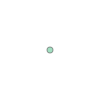

In [57]:
point

In [17]:
gdf = gpd.GeoDataFrame.from_features(streets)

In [22]:
line = gdf.iloc[0]['geometry']

In [24]:
crashes

,Unnamed: 0,REPORT NUMBER,BLOCK NUMBER,DATETIME,LATITUDE,LONGITUDE,severity,is_dry,is_light,is_clear,is_hit_run,TOTAL VEHICLES,TOTAL PEDESTRIANS INVOLVED,TOTAL BICYCLISTS INVOLVED
0,0,3773772,0.0,2019-04-19 15:52:00,47.606205,-122.319417,3,0,1,0,0,1,0,1
1,1,3773784,700.0,2017-06-27 06:40:00,47.626561,-122.320235,3,1,1,1,0,1,0,1
2,2,E779051,2100.0,2018-03-10 23:00:00,47.638665,-122.320075,3,0,0,0,1,1,0,1
3,3,3773767,1900.0,2017-07-02 15:13:00,47.636483,-122.320093,3,1,1,1,0,1,0,1
4,4,EA10570,600.0,2020-01-31 13:45:00,47.624503,-122.319881,3,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329,1329,E921701,NaN,2019-04-26 16:42:00,47.720114,-122.294792,3,1,1,1,0,1,0,1
1330,1330,EA50958,NaN,2020-05-18 16:44:00,47.723622,-122.292803,2,1,1,1,0,1,0,1
1331,1331,E686939,NaN,2017-06-21 17:21:00,47.734138,-122.334294,3,1,1,1,0,3,0,1
1332,1332,E930347,NaN,2019-06-09 14:44:00,47.733971,-122.312781,2,1,1,1,1,1,0,1
